# Notebook overview

The objective of this notebook is to offer a first approximation at Image Classification problems.

For this, we will be using a very popular library `PyTorch` and a DataSet of fruits and vegetables.



---


❗ **Before running the notebook in colab, go to the top menu: `Runtime` > `Change runtime type` > `Hardware accelerator` and select the option "T4 GPU" to ensure faster execution.**

In [1]:
!pip install -q eccd_datasets

In [2]:
import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import torch
import torchvision.transforms.v2 as transforms

from eccd_datasets import load_images
from PIL import Image
from torchvision import models

torch.manual_seed(42)

In [3]:
# Download the original lables used when training a resnet

resnet_labels = {
    int(index): label
    for index, (id, label) in requests.get(
        "https://files.fast.ai/models/imagenet_class_index.json"
    )
    .json()
    .items()
}
resnet_labels[10]

'brambling'

# Exploring the dataset

First, we invite you to go to the dataset folder and explore the content and structure of the project.

The dataset used in this notebook consists on a subset from the dataset located [here](https://github.com/marcusklasson/GroceryStoreDataset)

Once that is done, we can start looking at what is included in the dataset

In [4]:
df_images = load_images()
df_images.head()

,dataset,coarse_cat,finegrained_cat,image_data
0,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


### Looking at the images

We can use the `PIL` library to look at the images

In [5]:
def load_image_data(image_data):
    return Image.open(io.BytesIO(image_data))

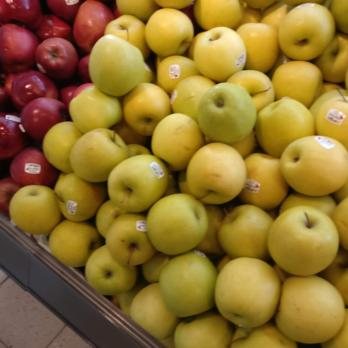

In [6]:
image = load_image_data(df_images.iloc[0]["image_data"])
image

### Images as matrices

We can also look look at the matrix representation of each image using numpy

In [7]:
I = np.array(image)
print("Image shape", I.shape)
print(f"Image range in each coordinate: [{I.min()}, {I.max()}]")

Image shape (348, 348, 3)
Image range in each coordinate: [0, 255]


And we can modify the image manually by changing the values of the matrix

In [8]:
new_I = I.copy()
new_I[:, :, 0] = 0 # Killing the red channel

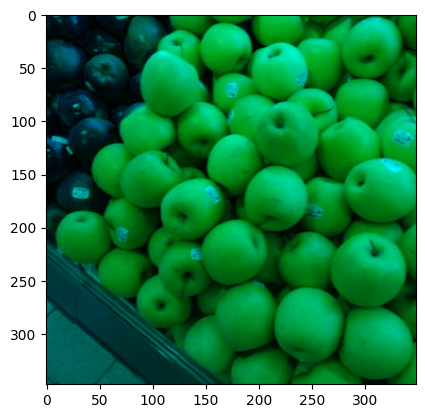

In [9]:
plt.imshow(new_I.astype(int))

# PyTorch Transformations

The same way we normalize tabular data with Standard and MinMax scalers, we need to normalize image data.

We will proceed to explore some of the most used transformations

## Resizing

In [10]:
resize_image = transforms.Resize((100, 100))

In [11]:
resized_image = resize_image(image)

Text(0.5, 1.0, 'New shape: (100, 100, 3)')

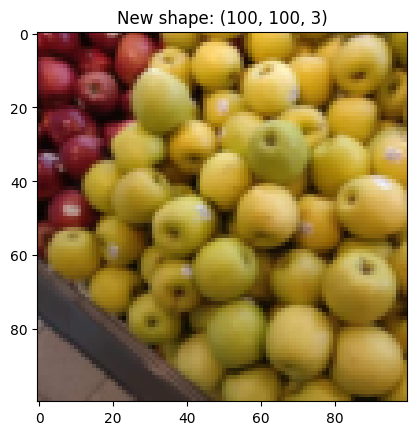

In [12]:
plt.imshow(resized_image)
plt.title(f"New shape: {np.array(resized_image).shape}")

## Center Crop

Implement a transformation for croping and centering (hint: there is a transformation that does that)

In [13]:
type(image)

PIL.JpegImagePlugin.JpegImageFile

In [14]:
def center_crop_transformation(image, size: int) -> np.array:
    """
    This function uses a pytorch transformation to
    center and crop the image
    """
    # Transformacion que recorta el centro de la imagen segun lo definido en size
    center_crop = transforms.CenterCrop(size)


    # Aplico la transformacion a la imagen
    cropped_image = center_crop(image)

    # Convierto la imagen recortada en un array
    return np.array(cropped_image)


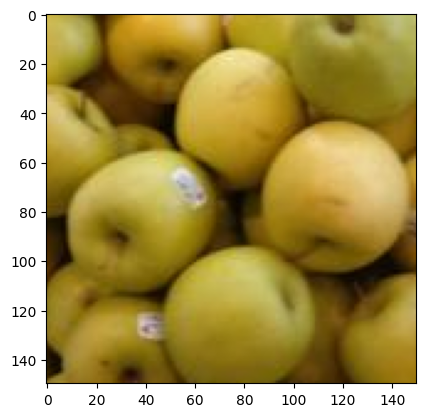

In [15]:
answer_center_crop = center_crop_transformation(image, 150)
plt.imshow(answer_center_crop)

In [16]:
assert np.array(answer_center_crop).shape == (150, 150, 3)

## RandomResizedCrop

Image original size:  (348, 348, 3)


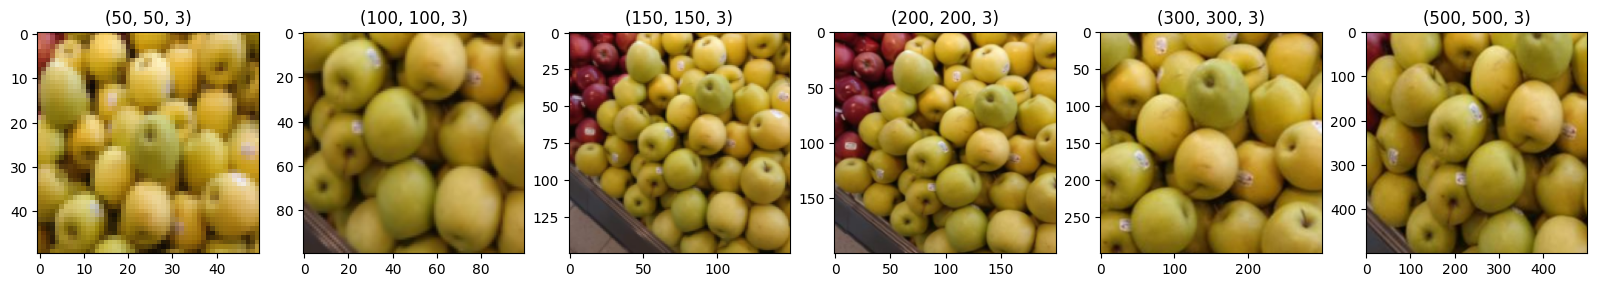

In [17]:
print("Image original size: ", np.array(image).shape)
fig, ax = plt.subplots(1, 6, figsize=(20, 4))
for i, size in enumerate([50, 100, 150, 200, 300, 500]):

    transformation = transforms.RandomResizedCrop(size)

    crp_img = transformation(image)
    ax[i].imshow(crp_img)
    ax[i].set_title(np.array(crp_img).shape)

## Random Horizontal Flip

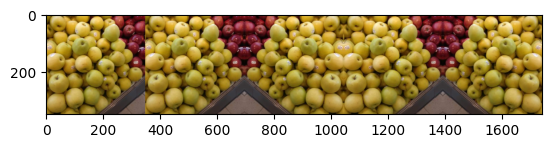

In [18]:
transformation = transforms.RandomHorizontalFlip()

maybe_flipped = [transformation(image) for _ in range(5)]

plt.imshow(np.hstack([np.array(img) for img in maybe_flipped]))

## Normalization

The same way we normalize columns for tabular data, here we normalize each image according to the mean and standard deviation of each colour channel.

In [19]:
two_images = [
    load_image_data(row["image_data"]) for _, row in df_images.iloc[:2].iterrows()
]

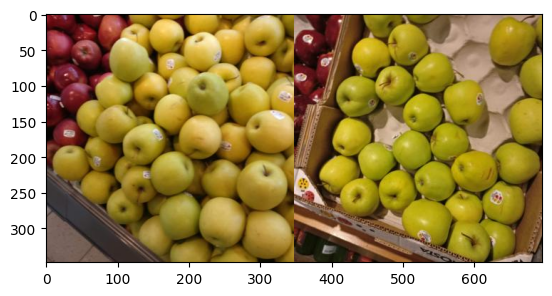

In [20]:
two_image_dataset = np.array([np.array(img) for img in two_images])
two_image_dataset.shape

plt.imshow(np.hstack([np.array(img) for img in two_images]))

In [21]:
two_image_dataset.shape

(2, 348, 348, 3)

In [22]:
np.mean(two_image_dataset, axis=(0, 1, 2))

array([141.43284285, 114.20849435,  44.61421588])

In [23]:
transformation = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(
            np.mean(two_image_dataset, axis=(0, 1, 2)),
            np.std(two_image_dataset, axis=(0, 1, 2)),
        ),
    ]
)

In [24]:
transformed_two_image_dataset = [transformation(img) for img in two_image_dataset]

In [25]:
transformed_two_image_dataset[0]

Image([[[-2.7367, -2.7360, -2.7363,  ..., -2.7344, -2.7344, -2.7344],
        [-2.7365, -2.7366, -2.7368,  ..., -2.7344, -2.7345, -2.7346],
        [-2.7361, -2.7369, -2.7372,  ..., -2.7346, -2.7347, -2.7347],
        ...,
        [-2.7394, -2.7394, -2.7396,  ..., -2.7357, -2.7357, -2.7355],
        [-2.7394, -2.7394, -2.7395,  ..., -2.7359, -2.7357, -2.7357],
        [-2.7394, -2.7395, -2.7395,  ..., -2.7360, -2.7359, -2.7357]],

       [[-2.1392, -2.1384, -2.1384,  ..., -2.1298, -2.1299, -2.1299],
        [-2.1390, -2.1389, -2.1389,  ..., -2.1299, -2.1300, -2.1300],
        [-2.1386, -2.1392, -2.1392,  ..., -2.1300, -2.1301, -2.1302],
        ...,
        [-2.1339, -2.1339, -2.1342,  ..., -2.1314, -2.1314, -2.1312],
        [-2.1339, -2.1339, -2.1340,  ..., -2.1315, -2.1314, -2.1314],
        [-2.1339, -2.1340, -2.1341,  ..., -2.1317, -2.1316, -2.1314]],

       [[-1.0914, -1.0904, -1.0904,  ..., -1.0913, -1.0914, -1.0914],
        [-1.0911, -1.0911, -1.0911,  ..., -1.0914, -1.0915, 

# Using ImageNet

Since training a large neural network requires lots of data and computing power, often we download a pre-trained neural network, which we can later fine-tune.

Here, we will download an ImageNet network.

Remember that since the network is already trained with a specific dataset, when evaluating new images, we need transform them using the same transformations used for training. In particular, that includes using the same normalizations.

In [26]:
resnet = models.resnet18(pretrained=True)
# resnet = models.resnet34(pretrained=True)
# resnet = models.resnet50(pretrained=True)
# resnet = models.resnet101(pretrained=True)
# resnet = models.resnet152(pretrained=True)
resnet.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We load a maping from resnet integer labels to the actual categories

In [36]:
def predict_using_resnet(image):
    """
    This image uses the resnet as is to
    predict an image.
    Remember to apply the correct transformations
    to the image before feeding it to the network.

    The following link might be useful: https://pytorch.org/hub/pytorch_vision_resnet/
    """

    # Defino las transformaciones de la imagen
    preprocess = transforms.Compose([
        transforms.Resize(256),                             # Tamaño de la imagen
        transforms.CenterCrop(224),                         # Recorto el centro
        transforms.ToTensor(),                              # Convierto a tensor de PyTorch
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),    # Normalizo
    ])

    # Aplico las transformaciones a la imagen
    img_t = preprocess(image)
    img_t = img_t.unsqueeze(0)  # Dimensión del batch

    # Realizo la predicción
    with torch.no_grad():       # Desactiva el cálculo de gradientes
        output = resnet(img_t)  # Pasa la imagen a través de la red

    # Obtengo la predicción
    _, predicted = torch.max(output, 1)

    # Devuelve la etiqueta correspondiente
    return  resnet_labels[predicted.item()]


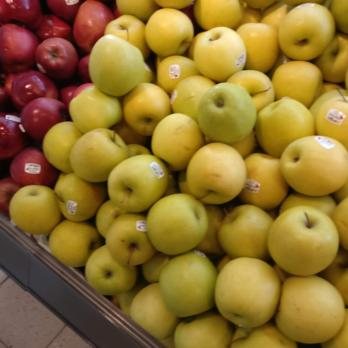

In [37]:
img1 = (
    load_image_data(
        df_images[
            df_images["coarse_cat"] == "Apple"
        ]
        .iloc[0]
        ["image_data"]
    )
)
img1

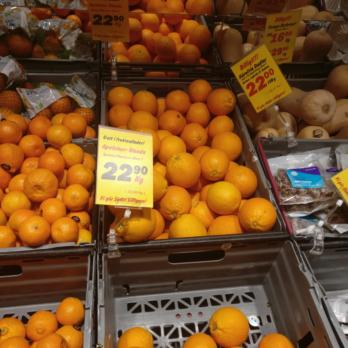

In [38]:
img2 = (
    load_image_data(
        df_images[
            df_images["coarse_cat"] == "Orange"
        ]
        .iloc[0]
        ["image_data"]
    )
)
img2

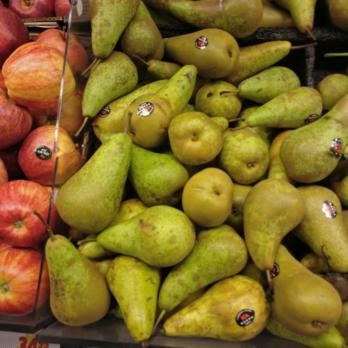

In [39]:
img3 = (
    load_image_data(
        df_images[
            df_images["coarse_cat"] == "Pear"
        ]
        .iloc[0]
        ["image_data"]
    )
)
img3

In [40]:
pred1 = predict_using_resnet(img1)

In [41]:
assert pred1 == "lemon"

In [42]:
pred2 = predict_using_resnet(img2)
print(pred2)

orange


In [43]:
pred3 = predict_using_resnet(img3)
print(pred3)

banana
